In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
train_df = pd.read_csv("input/train.csv")
train_df.drop('id', axis = 1,inplace = True)
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train_df.shape

(159571, 7)

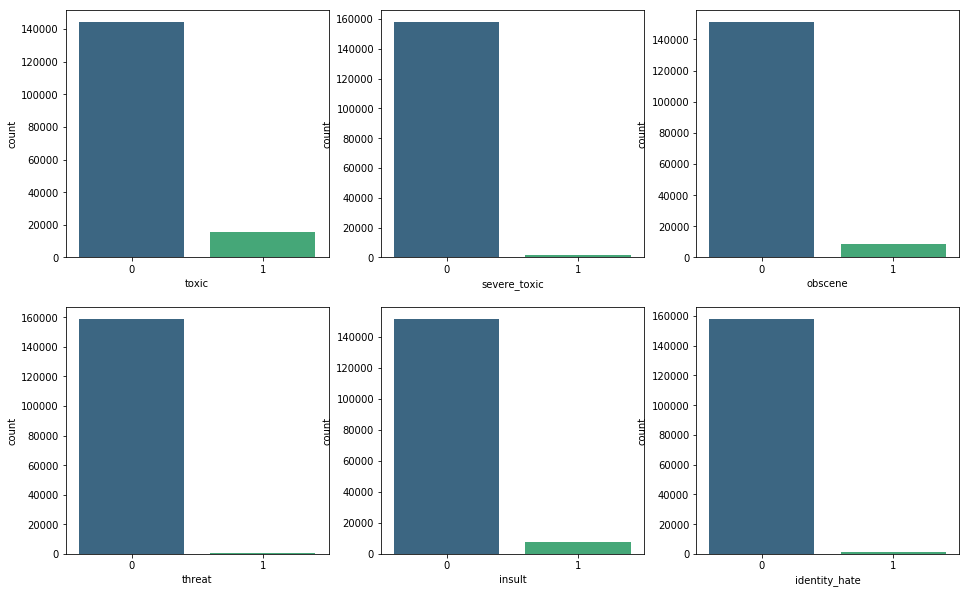

In [5]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train_df['toxic'],palette= 'viridis',ax=ax1)
sns.countplot(train_df['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train_df['obscene'], palette= 'viridis',ax=ax3)
sns.countplot(train_df['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train_df['insult'], palette = 'viridis',ax=ax5)
sns.countplot(train_df['identity_hate'], palette = 'viridis', ax = ax6)

In [6]:
test_df = pd.read_csv("input/test.csv")
test_df.drop('id', axis = 1,inplace = True)
test_df.head()

,comment_text
0,Yo bitch Ja Rule is more succesful then you'll...
1,== From RfC == \n\n The title is fine as it is...
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,":If you have a look back at the source, the in..."
4,I don't anonymously edit articles at all.


In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [8]:
# clean the comment_text in train_df
cleaned_train_comment = []
for i in range(0,len(train_df)):
    cleaned_comment = clean_text(train_df['comment_text'][i])
    cleaned_train_comment.append(cleaned_comment)
train_df['comment_text'] = pd.Series(cleaned_train_comment).astype(str)

In [9]:
cleaned_train_comment[100]

'however the moonlite edit noted by golden daph was me on optus wake up wikkis so funny'

In [10]:
## Test set
cleaned_test_comment = []
for i in range(0,len(test_df)):
    cleaned_comment = clean_text(test_df['comment_text'][i])
    cleaned_test_comment.append(cleaned_comment)
test_df['comment_text'] = pd.Series(cleaned_test_comment).astype(str)

In [11]:
target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import time
#import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(C=12.0,solver = 'liblinear')
vec_tfid = TfidfVectorizer(ngram_range=(1,2),min_df=3, max_df=0.9,
                           strip_accents='unicode', use_idf=1,smooth_idf=1,
                           sublinear_tf=1, max_features = 40000)
model_tab= {}
start = time.time()
for i,label in enumerate(target):
    print('... Processing {}'.format(label))
    X = train_df.comment_text
    y = train_df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    X_train_vec = vec_tfid.fit_transform(X_train)
    X_test_vec = vec_tfid.transform(X_test)
    logreg.fit(X_train_vec, y_train)
    model_tab[label] = logreg
    y_pred_class = logreg.predict(X_test_vec)
    y_pred_prob = logreg.predict_proba(X_test_vec)[:, 1]

    # calculate AUC
    model_accuracy = metrics.roc_auc_score(y_test, y_pred_prob)
    
    print('Class '+label)
    print('Accuracy is  : {0:.3g}%'.format(model_accuracy*100))
    print(metrics.confusion_matrix(y_test, y_pred_class))
    print('Five non-'+label+' comments classified as '+label)
    print("")
    false_class =  X_test[y_test < y_pred_class]
    i=0
    for x in false_class:
        if i<5 and len(x) < 100:
            print(str(i+1)+' - '+x)
            i+=1
    
    print(50*'_')
    
diff = time.time()-start
minutes, seconds = diff // 60, diff % 60
print('Excecution time : '+ str(minutes)+' min and '+str(seconds)+' s' )

... Processing toxic
Class toxic
Accuracy is  : 96.9%
[[35608   388]
 [ 1260  2637]]
Five non-toxic comments classified as toxic

1 - stop writing on my page you are only making things worse for yourself
2 - destroy all modernists make them pay for their hatred of stoicism and classicism
3 - maltese dog again
4 - pain damn right about the pain this thing is killing me
5 - condolences to you your wife and family my prayers are with you
__________________________________________________
... Processing severe_toxic
Class severe_toxic
Accuracy is  : 97.7%
[[39389   109]
 [  282   113]]
Five non-severe_toxic comments classified as severe_toxic

1 - hey fuck you you cocksucker i was talking to daymee you fucking retard
2 - you are a big dickhead your an asshole it was not me you utter bellend
3 - delete it and my ip address you stupid fucking faggot now
4 - fuck you motha fucka penis
5 - you are no fucking metal lord dumbass you are a fag fuck you
____________________________________________

### Exploring toxic and not toxic words

In [13]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

X_vec = vec_tfid.fit_transform(train_df.comment_text)
nb.fit(X_vec,train_df['toxic'])

# store the vocabulary of X_train
X_train_tokens = vec_tfid.get_feature_names()
len(X_train_tokens)

40000

In [14]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[ 92.74063701, 116.41671058,  11.46965061, ...,   7.71097107,
          0.840224  ,   0.77154478],
       [  4.48056129,   4.98450286,   0.74862852, ...,   0.20971683,
          0.48994778,   0.46563441]])

In [15]:

# number of times each token appears across all Not toxic messages
Not_Toxic_token_count = nb.feature_count_[0, :]
Not_Toxic_token_count

array([ 92.74063701, 116.41671058,  11.46965061, ...,   7.71097107,
         0.840224  ,   0.77154478])

In [16]:
# number of times each token appears across all Toxic messages
Toxic_token_count = nb.feature_count_[1, :]
Toxic_token_count

array([4.48056129, 4.98450286, 0.74862852, ..., 0.20971683, 0.48994778,
       0.46563441])

In [17]:
# create a DataFrame of tokens with their separate not toxic and toxic counts
tokens = pd.DataFrame({'token':X_train_tokens, 'Not_toxic':Not_Toxic_token_count, 'Toxic':Toxic_token_count}).set_index('token')
tokens.head()

,Not_toxic,Toxic
token,,
00,92.740637,4.480561
000,116.416711,4.984503
000 000,11.469651,0.748629
000 build,4.859878,0.000000
000 edits,5.117145,0.798637


In [18]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state=123)

,Not_toxic,Toxic
token,,
the late,23.311213,0.804122
senators,5.429543,0.219870
calendar,18.261965,0.325213
think about,48.496000,6.062700
tickets,5.210887,0.518902


In [19]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([144277.,  15294.])

In [20]:
# add 1 to not toxic and toxic counts to avoid dividing by 0
tokens['Not_toxic'] = tokens.Not_toxic + 1
tokens['Toxic'] = tokens.Toxic + 1
tokens.sample(5, random_state=123)

,Not_toxic,Toxic
token,,
the late,24.311213,1.804122
senators,6.429543,1.219870
calendar,19.261965,1.325213
think about,49.496000,7.062700
tickets,6.210887,1.518902


In [21]:
# convert the ham and spam counts into frequencies
tokens['Not_toxic']  = tokens.Not_toxic  / nb.class_count_[0]
tokens['Toxic']  = tokens.Toxic / nb.class_count_[1]
tokens.sample(5, random_state=123)

,Not_toxic,Toxic
token,,
the late,0.000169,0.000118
senators,0.000045,0.000080
calendar,0.000134,0.000087
think about,0.000343,0.000462
tickets,0.000043,0.000099


In [22]:
# calculate the ratio of toxic to non-toxic for each token
tokens['spam_ratio'] = tokens.Toxic/ tokens.Not_toxic
tokens.sample(10, random_state=123)

,Not_toxic,Toxic,spam_ratio
token,,,
the late,0.000169,0.000118,0.700060
senators,0.000045,0.000080,1.789820
calendar,0.000134,0.000087,0.649025
think about,0.000343,0.000462,1.346098
tickets,0.000043,0.000099,2.307024
dis,0.000048,0.000358,7.468168
him it,0.000056,0.000120,2.138449
higher than,0.000074,0.000082,1.109370
finding freely,0.000037,0.000065,1.754843


In [23]:
# examine the DataFrame sorted by spam_ratio
tokens.sort_values('spam_ratio', ascending=False)

,Not_toxic,Toxic,spam_ratio
token,,,
fuck you,0.000014,0.013771,1017.628738
fuck,0.000069,0.033250,478.750356
fuck yourself,0.000009,0.004085,445.654132
you fucking,0.000010,0.004426,442.251036
go fuck,0.000012,0.005026,412.736865
fucking,0.000053,0.020091,382.277085
suck my,0.000009,0.003175,357.582048
fuck off,0.000019,0.006626,350.450002
motherfucker,0.000008,0.002681,342.467819


# Test Area:

In [24]:
x_dtm = vec_tfid.fit_transform(train_df.comment_text)

In [25]:
comment = ['I will kill you']
comment_vec = vec_tfid.transform(comment)
for label in model_tab:
    model = model_tab[label]
    y = train_df[label]
    logreg.fit(x_dtm, y)
    pred_prob = model.predict_proba(comment_vec)[:,1][0]
    print('Proba of '+label+' = {0:.3g}'.format(pred_prob))

Proba of toxic = 0.998
Proba of severe_toxic = 0.0101
Proba of obscene = 0.177
Proba of threat = 0.998
Proba of insult = 0.0255
Proba of identity_hate = 0.0186
